**Realizado por**: José Javier Díaz González

**Correo**: alu0101128894@ull.edu.es

# Problema del Viajante de Comercio (TSP) - The Traveling Salesman Problem

El Problema del Viajante de Comercio ("Traveling Salesman Problem") busca un circuito que visite una vez cada uno de los nodos de un grafo, con el menos coste posible de recorrido del circuito. 
El ejercicio es importante porque muestra que pueden existir varios modelos para un mismo problema, y que no todos los modelos de un problema requieren el mismo tiempo de cálculo para ser resueltos. 
De este ejercicio sobre el TSP aprenderemos a reconocer modelos buenos y modelos malos. 

In [1]:
# Definimos el tamaño del problema
n   = 25
V   = range(n)        # Conjunto de localizaciones
V0  = range(1,n)     # Conjunto de localizaciones sin el depósito
EPS = 0.001

# Generamos puntos en el plano
import random
random.seed(1)
points   = [(random.randint(0,100),random.randint(0,100)) for i in V]

Definimos una función para dibujar los puntos y la ruta.


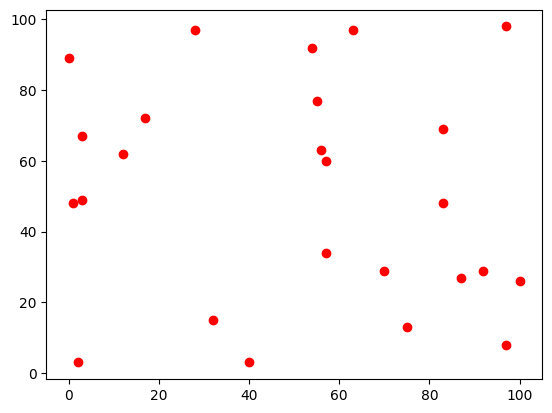

In [2]:
import matplotlib.pyplot as plt

# Función que dibuja
def dibuja(selected):                #dibuja una ruta dada como una lista de arcos
    plt.plot([p[0] for p in points], [p[1] for p in points], 'ro')
    #plt.plot([p[0] for p in range(1)], [p[1] for p in range(1)], 'bo')
    for (i,j) in selected:
        plt.plot([points[i][0],points[j][0]], [points[i][1],points[j][1]], 'b-')
    plt.show()

dibuja({})


## Representación de ejemplos con distancias euclídeas

A fin de que se vea algo con sentido, vamos a colocar puntos en el plano y a utilizar las distancias euclídeas entre ellos. Esto genera matrices de costos simétricas, es decir, donde $c_{ij}=c_{ji}$. Centrándonos ahora exclusivamente en distancias Euclideas para con ello "ver" la solución.

Definimos una matriz de costos 

In [3]:
import math
import numpy as np
cost =  np.zeros((n,n))
# Matriz de costos
for i in V :
  for j in V:
    if j != i:
      dx = points[i][0] - points[j][0]
      dy = points[i][1] - points[j][1]
      # El costo es igual a la distancia euclídea
      cost[i,j] = math.floor(math.sqrt(dx*dx + dy*dy))
      # Con esta otra hacemos que la matriz de costos no sea simétrica
      # cost[i,j] = math.floor(math.sqrt(dx*dx + dy*dy)*random.uniform(1.0, 1.2))
        


## Cuatro modelos para el TSP

Usando OR-tools como marco de trabajo, GLOP como librería de programación lineal continua y CBC como librería de optimización lineal entera, mostramos cuatro modelos para el TSP:

In [4]:
!pip install ortools
from ortools.linear_solver import pywraplp


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
""" Definimos una fución que resuleve el TSP con cuatro modelos diferentes
 p = Con restricciones/variables de precendencia
 u = Con variables de posción
 f = Con variables de flujo
 g = con variables multiflujo
 Además distinguimos si lo resuleve sin la condición de integrabilidad ('LP') o con la condición de integrabilidad ('IP') 
 Llamamos a esta función ATSP porque resuelve el Asymetric TSP.
 En este estos ejemplos hemos generado los costos o distancias de forma simétrica pero en general c_ij no es igual a c_ji)"""

selected = {}

def ATSP(var,tipo):
    if tipo == 'LP':
        solver = pywraplp.Solver('ATSPxLP', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
        x = { (i,j) : solver.NumVar(0.0, solver.infinity(), 'x[%i,%i]' % (i,j)) for i in V for j in V if i!=j }
    else:
        solver = pywraplp.Solver('ATSPxIP', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
        x = { (i,j) : solver.BoolVar('x[%i,%i]' % (i,j)) for i in V for j in V if i!=j }
       
    solver.Minimize(solver.Sum( cost[i,j]*x[i,j] for i in V for j in V if i!=j ))   # Función Objetivo: el coste mínimo de todos los arcos necesarios
    [ solver.Add( solver.Sum( x[i,j] for j in V if j!=i) == 1 )  for i in V ]     # El sumatorio de todos los
    [ solver.Add( solver.Sum( x[i,j] for i in V if j!=i) == 1 )  for j in V ]

    if var == "p" :
        p = { (i,j) : solver.NumVar(0, solver.infinity(), 'p[%i,%i]' % (i,j)) for i in V0 for j in V0 if i!=j }   # La suma de las dos debe ser uno
        [ solver.Add( p[i,j] + p[j,i] == 1 )          for i in V0 for j in V0 if j!=i ]
        [ solver.Add( p[i,j] + p[j,k] + p[k,i] <= 2 ) for i in V0 for j in V0 for k in V0 if i!=j and i!=k and j!=k ]
        [ solver.Add( p[i,j] >= x[i,j]  )             for i in V0 for j in V0 if j!=i ]

    if var == "u" :
        u = { i : solver.NumVar(0.0, solver.infinity(), 'u[%i]' % i) for i in V0 }
        [ solver.Add( u[j] >= u[i] + x[i,j] - (n-2)*(1-x[i,j]) + (n-3)*x[j,i]   ) for i in V0 for j in V0 if j!=i ]

    if var == "f" :
        f = { (i,j) : solver.NumVar(0.0, solver.infinity(), 'f[%i,%i]' % (i,j)) for i in V for j in V if i!=j }
        [ solver.Add( solver.Sum(f[j,i]-f[i,j] for j in V if j!=i) >= 1 )  for i in V0 ] 
        [ solver.Add(            f[i,j] <= (n-1)*x[i,j]           )    for i in V for j in V if i!=j ]
        
    if var == "g" :
        f = { (i,j,k) : solver.NumVar(0.0, solver.infinity(), 'f[%i,%i,%i]' % (i,j,k)) for i in V for j in V for k in V0 if i!=j}
        [ solver.Add( solver.Sum(f[j,i,k]-f[i,j,k] for j in V if j!=i) == 0 )  for i in V0 for k in V0 if k!= i ] 
        [ solver.Add( solver.Sum(f[j,i,i]-f[i,j,i] for j in V if j!=i) == 1 )  for i in V0 ] 
        [ solver.Add(            f[i,j,k] <= x[i,j]           )   for i in V for j in V for k in V0 if i!=j ]

    solver.Solve()
    print('Modelo con ',var,' y ',tipo,' opt=', solver.Objective().Value(),' en ', solver.WallTime()/1000, " segundos")
    global selected
    selected = [(i,j) for i in V for j in V if i!=j if x[i,j].solution_value() > EPS]
    
    # Comentar si no se quiere que se saque todas esta información
    [print('x[',i,',',j,'] =', x[i,j].solution_value()) for i in V for j in V  if i!=j if x[i,j].solution_value() > EPS ]


In [7]:
ATSP('u','LP')

Modelo con  u  y  LP  opt= 466.00000000000006  en  0.069  segundos
x[ 0 , 7 ] = 1.0
x[ 1 , 14 ] = 0.5
x[ 1 , 19 ] = 0.5000000000000002
x[ 2 , 15 ] = 0.5000000000000003
x[ 2 , 16 ] = 0.4999999999999997
x[ 3 , 10 ] = 0.4999999999999998
x[ 3 , 20 ] = 0.5000000000000004
x[ 4 , 9 ] = 0.5
x[ 4 , 23 ] = 0.5
x[ 5 , 12 ] = 0.5000000000000002
x[ 5 , 17 ] = 0.5
x[ 6 , 1 ] = 0.5
x[ 6 , 13 ] = 0.4999999999999999
x[ 7 , 0 ] = 0.5
x[ 7 , 8 ] = 0.5
x[ 8 , 18 ] = 1.0
x[ 9 , 4 ] = 0.4999999999999996
x[ 9 , 23 ] = 0.5
x[ 10 , 3 ] = 0.5000000000000003
x[ 10 , 17 ] = 0.4999999999999999
x[ 11 , 0 ] = 0.5
x[ 11 , 22 ] = 0.5
x[ 12 , 5 ] = 0.4999999999999991
x[ 12 , 24 ] = 0.5000000000000002
x[ 13 , 6 ] = 0.5000000000000002
x[ 13 , 19 ] = 0.4999999999999998
x[ 14 , 1 ] = 0.4999999999999999
x[ 14 , 24 ] = 0.5
x[ 15 , 2 ] = 0.4999999999999998
x[ 15 , 16 ] = 0.5000000000000003
x[ 16 , 2 ] = 0.5000000000000002
x[ 16 , 15 ] = 0.5
x[ 17 , 5 ] = 0.5
x[ 17 , 10 ] = 0.5000000000000002
x[ 18 , 21 ] = 1.0
x[ 19 , 6 ] = 0

In [8]:
ATSP('p','LP')
ATSP('u','LP')
ATSP('f','LP')
# Este ejemplo con las variables g tarda demasiado.
ATSP('g','LP')

ATSP('p','IP')
ATSP('u','IP')
ATSP('f','IP')
# Este ejemplo con las variables g tarda demasiado.
ATSP('g','IP')

Modelo con  p  y  LP  opt= 0.0  en  0.864  segundos
Modelo con  u  y  LP  opt= 466.00000000000006  en  0.042  segundos
x[ 0 , 7 ] = 1.0
x[ 1 , 14 ] = 0.5
x[ 1 , 19 ] = 0.5000000000000002
x[ 2 , 15 ] = 0.5000000000000003
x[ 2 , 16 ] = 0.4999999999999997
x[ 3 , 10 ] = 0.4999999999999998
x[ 3 , 20 ] = 0.5000000000000004
x[ 4 , 9 ] = 0.5
x[ 4 , 23 ] = 0.5
x[ 5 , 12 ] = 0.5000000000000002
x[ 5 , 17 ] = 0.5
x[ 6 , 1 ] = 0.5
x[ 6 , 13 ] = 0.4999999999999999
x[ 7 , 0 ] = 0.5
x[ 7 , 8 ] = 0.5
x[ 8 , 18 ] = 1.0
x[ 9 , 4 ] = 0.4999999999999996
x[ 9 , 23 ] = 0.5
x[ 10 , 3 ] = 0.5000000000000003
x[ 10 , 17 ] = 0.4999999999999999
x[ 11 , 0 ] = 0.5
x[ 11 , 22 ] = 0.5
x[ 12 , 5 ] = 0.4999999999999991
x[ 12 , 24 ] = 0.5000000000000002
x[ 13 , 6 ] = 0.5000000000000002
x[ 13 , 19 ] = 0.4999999999999998
x[ 14 , 1 ] = 0.4999999999999999
x[ 14 , 24 ] = 0.5
x[ 15 , 2 ] = 0.4999999999999998
x[ 15 , 16 ] = 0.5000000000000003
x[ 16 , 2 ] = 0.5000000000000002
x[ 16 , 15 ] = 0.5
x[ 17 , 5 ] = 0.5
x[ 17 , 10 ] = 0

Observa que cuando no se exige la condición de integrabilidad las soluciones de los modelos no son iguales. Cuando sí se exige la condición de integrabilidad el valor óptimo sí es el mismo (como cabía esperar).

También observa que los tiempos de ejecución son diferentes entre unos modelos y otros. 
Se podría probar cambiando la semilla y/o tamaño para ver si este comportamiento es general para varios ejemplos diferentes.


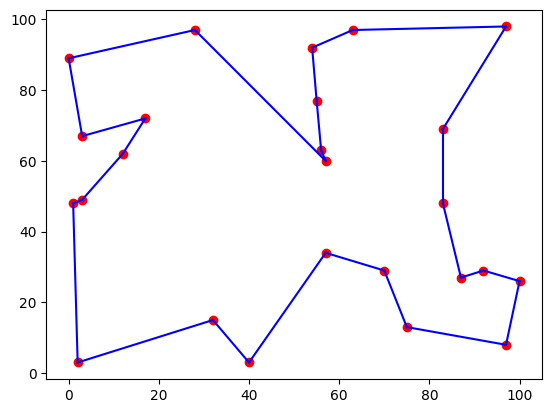

In [9]:
dibuja(selected)

## Modelo con generación dinámica de filas 

Mostramos ahora un modelo no compacto, es decir, con un enorme número de restricciones que no pueden ser generadas todas juntas, pero que sí son muy simples de utilizar dinámicamente a medida que van siendo necesarias. Es la formulación propuesta por Dantzig, Fulkerson y Johnson (1954) para el TSP, y hace uso de las llamadas "restricciones de eliminación de subciclos" (SEC "Subtour Elimination Constraints"): $$\sum_{i,j\in S} x_{ij} \leq |S|-1 \qquad \forall S \subset V.$$

Estas desigualdades anteriores son equivalentes a $$\sum_{i\in S} \sum_{j\not\in S} x_{ij} \geq 1 \qquad \forall S \subset V.$$ Notemos que podríamos reducir la cantidad de desigualdades en ambas familias limitándonos sólo a los subconjuntos que no contienen un nodo cualquiera, por ejemplo, $S\subset V\setminus\{1\}$. No es una gran reducción, pero es válida.

También sería valido quedarnos con sólo las desigualdades en las que $|S| \leq n/2$.

In [10]:
!pip install networkx


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Valor objetivo = 423.0
[{0, 21, 7}, {1, 14}, {16, 2, 15}, {10, 3}, {4, 23}, {17, 5}, {19, 13, 6}, {8, 18}, {9, 20}, {11, 22}, {24, 12}]


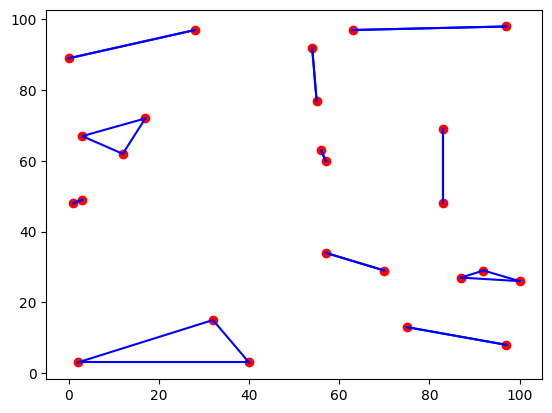

Valor objetivo = 470.0
[{0, 7, 11, 21, 22}, {1, 5, 6, 12, 13, 14, 19, 24}, {2, 15}, {3, 20}, {9, 4, 23}, {8, 16, 18}, {17, 10}]


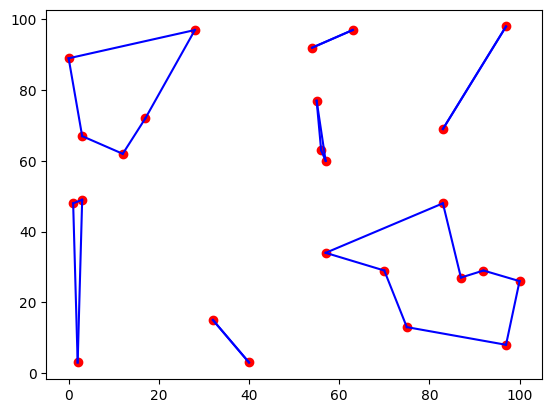

Valor objetivo = 492.0
[{0, 7, 8, 11, 18, 21, 22}, {1, 6}, {16, 2}, {3, 4, 5, 9, 10, 17, 20, 23}, {24, 12, 14, 15}, {19, 13}]


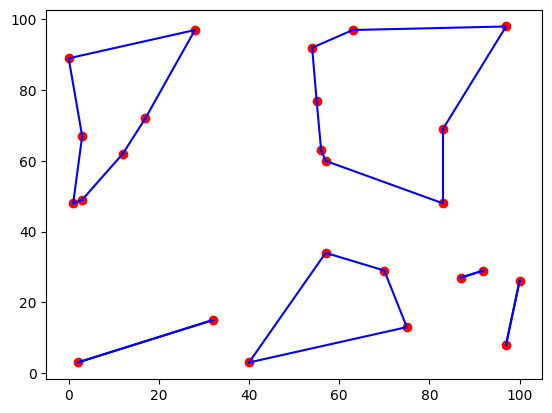

Valor objetivo = 498.0
[{0, 7}, {1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}]


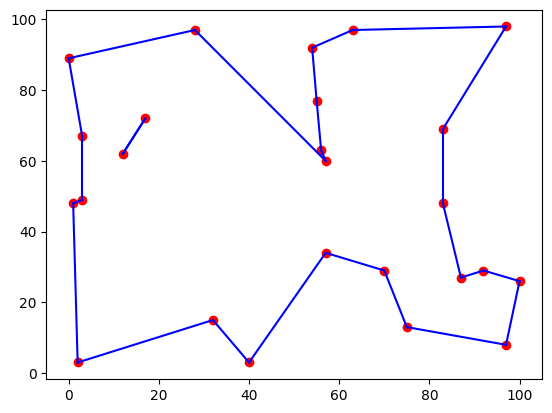

Valor óptimo = 498.0  en  1.936  segundos


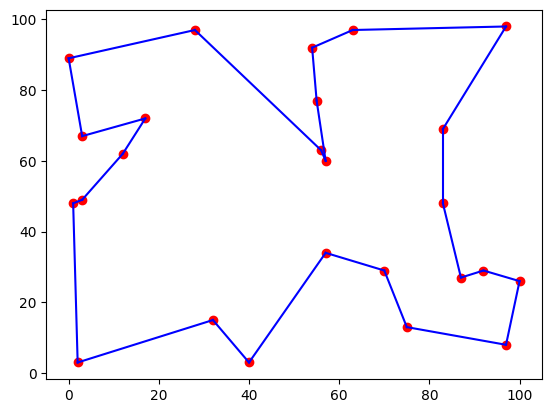

In [12]:
#Definimos la variables x como antes 

solver = pywraplp.Solver('ATSPsec', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
x = { (i,j) : solver.BoolVar('x[%i,%i]' % (i,j)) for i in V for j in V if i!=j }
       
solver.Minimize(solver.Sum( cost[i,j]*x[i,j] for i in V for j in V if i!=j ))

        
import networkx as nx
def SEC():
    G = nx.Graph()
    selected = [(i,j) for i in V for j in V if i!=j if x[i,j].solution_value() > EPS]  #variables mayores que cero
    G.add_edges_from( selected )
    Components = list(nx.connected_components(G))
    return(Components)

def ATSPsec():
    [ solver.Add( solver.Sum( x[i,j] for j in V if j!=i) == 1 )  for i in V ]
    [ solver.Add( solver.Sum( x[i,j] for i in V if j!=i) == 1 )  for j in V ]

    solver.Solve()
    time = solver.WallTime()/1000 
    Comp = SEC()
    while len(Comp) > 1:
        # Si no quiere más información, comentar estas líneas
        print('Valor objetivo =', solver.Objective().Value())
        print(Comp)
        selected = [(i,j) for i in V for j in V if i!=j if x[i,j].solution_value() > EPS]
        dibuja(selected)
        for S in Comp:
            if(len(S) <= n/2) : 
                solver.Add( solver.Sum( x[i,j] for i in S for j in S if j!=i) <= len(S)-1 ) 
        solver.Solve()
        time += solver.WallTime()/1000 
        Comp = SEC()

    print('Valor óptimo =', solver.Objective().Value(),' en ', time, " segundos")
    selected = [(i,j) for i in V for j in V if i!=j if x[i,j].solution_value() > EPS]
    dibuja(selected)
    
ATSPsec()
